In [53]:
import os
import subprocess
import pandas as pd
import re

# Method Analysis

Iterate through compression methods, available in the zipfile standard Python library, and compression effort levels, evaluated by compression ratio and run time. 

In [2]:
compression_methods = ["ZIP_DEFLATED", "ZIP_BZIP2", "ZIP_LZMA", "ZIP_STORED"]
compression_efforts = list(range(0,10))

## Script run for single set of parameters

In [33]:
'''
The code below does not work because the encode and decode scripts don't seem 
to be doing anything when run using the subprocess library. Not sure why but 
I will fix this later.
'''

"\nThe code below does not work because the encode and decode scripts don't seem \nto be doing anything when run using the subprocess library. Not sure why but I will fix this later\n"

In [30]:
# def run_bash_command(command):
#     process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
#     stdout, stderr = process.communicate()
#     return stdout, stderr, process.returncode

# command = 'cd ../ && ./eval.sh ZIP_DEFLATED 0'
# stdout, stderr, returncode = run_bash_command(command)

In [34]:
# print(stdout)

In [35]:
# df = pd.read_csv('../compression_results.csv')
# df

In [36]:
# list_of_df = []
# list_of_df.append(df)
# list_of_df

In [37]:
# print(result.stdout)

## Collecting Data for All Parameters

In [38]:
# list_of_df = [[0 for i in compression_efforts] for j in compression_methods]

In [39]:
# for i in range(len(compression_methods)):
#     for j in range(len(compression_efforts)):
#         method = compression_methods[i]
#         effort = compression_efforts[j]
#         command = f"cd ../ && ./eval.sh {method} {effort}"
#         stdout, stderr, returncode = run_bash_command(command)
#         df = pd.read_csv('../compression_results.csv')
#         list_of_df[i][j] = df.copy()
# print("done")

In [40]:
# list_of_df

In [41]:
# list_of_df[0][0]

Currently, the code above does not work due to some flaw with how I used the subprocess library. Instead, I have writen a script ./iterate_eval.sh in the same ./separate_zip_py_coding/ folder to iterate the data collection process. I have also included a copy of the eval script that I used for this, incase the eval script is modified later and someone wishes to reproduce the results.

In [43]:
# sizes for the encode and decode scripts (used for compression ratio calculation)
encode_size_bytes = 1283
decode_size_bytes = 536

## Analysing results

In [99]:
list_of_delay = [[0 for i in compression_efforts] for j in compression_methods]
list_of_max_delay = [[0 for i in compression_efforts] for j in compression_methods]
list_of_min_delay = [[0 for i in compression_efforts] for j in compression_methods]
list_of_ratios = [[0 for i in compression_efforts] for j in compression_methods]

In [100]:
results_dir = "../results"

In [101]:
pattern = r'compression_results_([A-Z_]+2?)_(\d+)\.csv$'

In [102]:
for file in os.listdir(results_dir):
    match = re.search(pattern, file)
    if match:
        method = match.group(1)
        effort = int(match.group(2))
        method_index = compression_methods.index(method)
        df = pd.read_csv(os.path.join(results_dir, file))
        total_original_size = df['file_size'].sum()
        total_compressed_size = df['compressed_size'].sum() + encode_size_bytes + decode_size_bytes # includes the sizes of the encoder and decoder
        compression_ratio = total_original_size / total_compressed_size
        average_delay = df['time_taken_ns'].mean()
        max_delay = df['time_taken_ns'].max()
        min_delay = df['time_taken_ns'].min()
        list_of_ratios[method_index][effort] = compression_ratio
        list_of_delay[method_index][effort] = average_delay
        list_of_max_delay[method_index][effort] = max_delay
        list_of_min_delay[method_index][effort] = min_delay
    else:
        print(f"error: could not find for {file}")
    

In [104]:
import matplotlib.pyplot as plt
import numpy as np

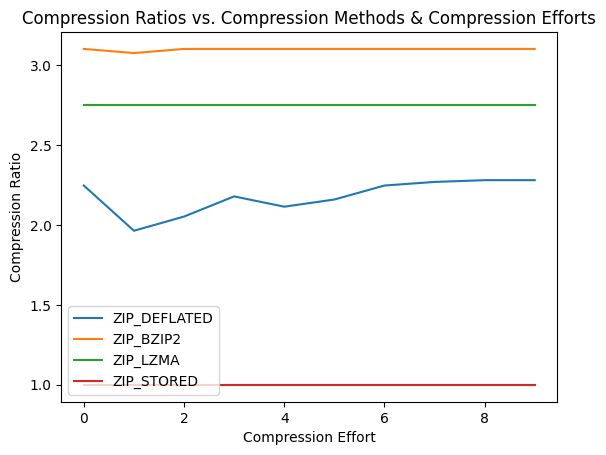

In [105]:
x = np.linspace(0,9, 10)
for i,ratios_for_method in enumerate(list_of_ratios):
    plt.plot(x, ratios_for_method, label=compression_methods[i])
plt.xlabel('Compression Effort')
plt.ylabel('Compression Ratio')
plt.title("Compression Ratios vs. Compression Methods & Compression Efforts")
plt.legend()


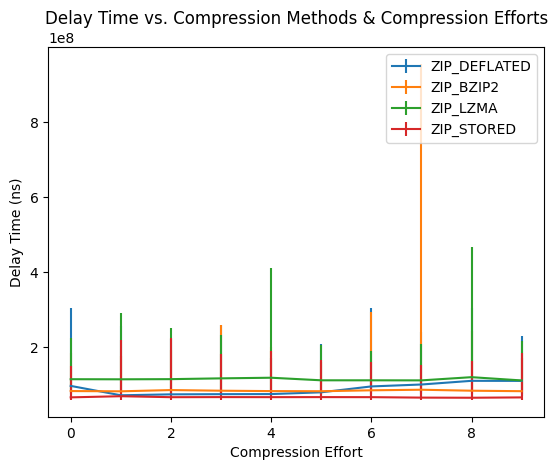

In [111]:
x = np.linspace(0,9, 10)
list_of_delay = np.array(list_of_delay)
list_of_max_delay = np.array(list_of_max_delay)
list_of_min_delay = np.array(list_of_min_delay)
list_of_upper_error = list_of_max_delay - list_of_delay
list_of_lower_error = list_of_delay - list_of_min_delay
list_of_errors = [[list_of_lower_error[i], list_of_upper_error[i]] for i in range(len(compression_methods))]


for i,lst_delay in enumerate(list_of_delay):
    plt.errorbar(x, lst_delay, yerr=list_of_errors[i], label=compression_methods[i])
plt.xlabel('Compression Effort')
plt.ylabel('Delay Time (ns)')
plt.title("Delay Time vs. Compression Methods & Compression Efforts")
plt.legend()



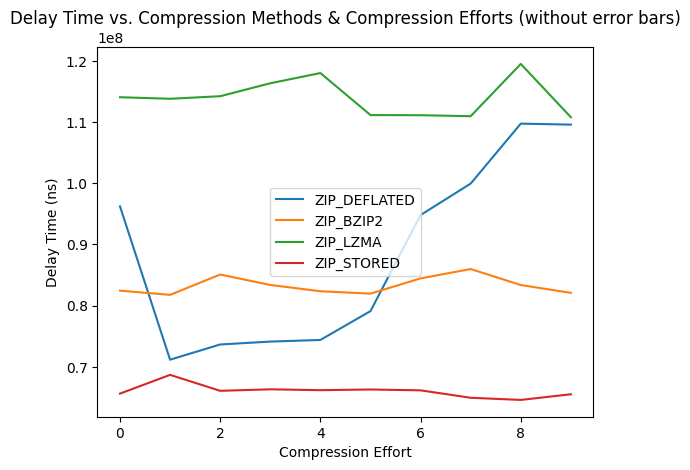

In [110]:
for i,lst_delay in enumerate(list_of_delay):
    plt.plot(x, lst_delay, label=compression_methods[i])
plt.xlabel('Compression Effort')
plt.ylabel('Delay Time (ns)')
plt.title("Delay Time vs. Compression Methods & Compression Efforts (without error bars)")
plt.legend()

It seems ZIP_BZIP2 is the most effective out of the 4 algorithms the standard zipfile library can use with a compression ratio of ~3.1, and generally is the "fastest" algorithm other than when ZIP_DELATED has a compression effort between 1-5. Of course, suitability of the methods is hard to evaluate without actually looking into the algorithms and assessing how viable it is to implement them in hardware.

I should also note that the times seem to show that the time for compression with these methods (for each electrode) is on the order of 100ms-1s, which seems wrong. I am certain these are related to startup times of software. My hunch is that once these are implemented directly in hardware, it should be managable to bring the processing time under 1ms. We'll see how much of difference we see when we attempt with the same algorithms in C - that should give us a better indicator. 

Note that the `compression_effort` parameter only has effect for ZIP_DEFLATED and ZIP_BZIP2, when specified for the other algorithms they are effectively ignored. ZIP_STORED is equivalent to not applying any compression algorithm to the data.

# Credits

Reuben Thomas - reubenkthomas@berkeley.edu;